# Example

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# * 探索代码
# Functional Test
from tqdm import tqdm
from detector.online_arima import OnlineARIMA
from detector.online_stl import OnlineSTL
from detector.online_svr import OnlineSVR
from distribution.kde import KDE
# 生成测试数据
x=np.linspace(0,8*2*np.pi,8*1440)
y=0.8 * np.sin(x) + 0.10 * np.random.randn(8 * 1440)
series = pd.Series(y)
# 注入异常
for i in range(7000, 7035):
    y[i] = 2.0
# series.plot.line()

# 预热detector
arima = OnlineARIMA(series[0:4*1440])
stl = OnlineSTL(series[0:4*1440])
svr = OnlineSVR(series[0:4*1440])

# 预热distribution
Xhat_arima = []
Xhat_stl   = []
Xhat_svr   = []
for i in tqdm(range(3 * 1440, 4 * 1440)):
    xhat_arima = arima.update(series[i])
    xhat_stl = stl.update(series[i])
    xhat_svr = svr.update(series[i])

    Xhat_arima.append(xhat_arima)
    Xhat_stl.append(xhat_stl)
    Xhat_svr.append(xhat_svr)
# 初始化分布
kde_arima = KDE(Xhat_arima)
kde_stl = KDE(Xhat_stl)
kde_svr = KDE(Xhat_svr)

from ensemble.merge import Merge
# 在线检测
merge = Merge()

Yhat = []
for i in tqdm(range(4 * 1440, 8 * 1440)):
    xhat_arima = arima.update(series[i])
    xhat_stl = stl.update(series[i])
    xhat_svr = svr.update(series[i])

    yhat_arima = kde_arima.step(xhat_arima)
    yhat_stl = kde_stl.step(xhat_stl)
    yhat_svr = kde_svr.step(xhat_svr)

    yhat = merge.ensemble(pd.Series([yhat_arima, yhat_stl, yhat_svr]))

    Yhat.append(yhat)
# pd.Series(Xhat).plot.line()

  0%|          | 0/1410 [00:00<?, ?it/s]d:\ensemble2\detector\online_svr.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minValues = np.array([Lc1, Lc2, Ls[minLsIndex], Le[minLeIndex], Lr[minLrIndex]])
100%|██████████| 5760/5760 [09:56<00:00,  9.65it/s]


<AxesSubplot:>

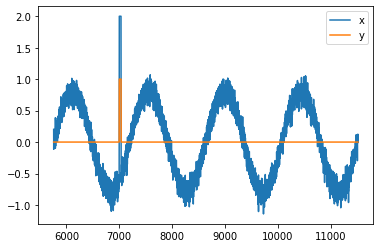

In [8]:
pd.DataFrame({'x': series[4*1440:8*1440], 'y': Yhat}).plot.line()

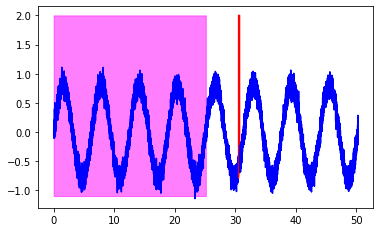

In [43]:
x=np.linspace(0,8*2*np.pi,8*1440)
y=0.8 * np.sin(x) + 0.10 * np.random.randn(8 * 1440)
series = pd.Series(y)
# 注入异常
for i in range(7000, 7035):
    y[i] = 2.0

plt.figure(figsize=(6, 6*0.618))

plt.plot(x[0*1440:7000-2], series[0*1440:7000-2], color='blue')
plt.plot(x[7000-2:7035+2], series[7000-2:7035+2], color='red')
plt.plot(x[7035+2:8*1440], series[7035+2:8*1440], color='blue')

plt.fill_between(
    x=x[0*1440:4*1440],
    y1=-1.1,
    y2=2.0,
    color='magenta',
    alpha=0.5,
    label='KDE',
)

plt.show()